# Autor: José Miguel Ramírez Sanz
## Descripción: Notebook para primeras pruebas con las primeras versiones de la clase posición y la comparación

In [1]:
# imports
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import math
import os
import pandas as pd
import pickle as pk
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

# import de utilities de detectron
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

### Se carga el modelo

In [2]:
#Carga del modelo
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.99  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

### Se lee la imagen y se procesa para sacar el esqueleto

In [3]:
#Lectura de la imagen
frame = cv2.imread("../pruebas/imagenes-prueba/p.jpeg")
o = predictor(frame)
pkP = o.get("instances").pred_keypoints
if len(pkP)>0:
    x = pkP[0][:,0].cpu().numpy()
    y = pkP[0][:,1].cpu().numpy()

### Se imprime la imagen con el esqueleto estimado

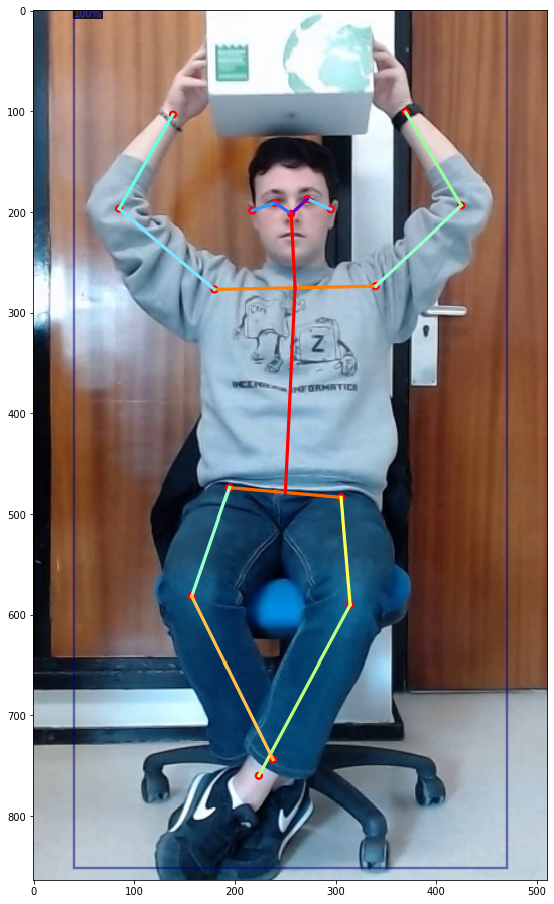

In [4]:
v = Visualizer(frame[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v2 = v.draw_instance_predictions(o["instances"].to("cpu"))
imVisualizer = cv2.cvtColor(v2.get_image()[:, :, ::-1],cv2.COLOR_BGR2RGB)
plt.figure(figsize=(18, 16))
plt.imshow(imVisualizer)
plt.show()

### Se observa la estructura de la salida

In [5]:
x

array([213.49094, 226.98407, 199.99782, 246.41414, 181.10745, 283.11545,
       150.34314, 354.3591 ,  71.00359, 307.94278, 115.80075, 255.04974,
       162.21709, 262.6059 , 131.45277, 186.5047 , 198.37865],
      dtype=float32)

In [6]:
y

array([169.78755, 157.37067, 160.60986, 166.00851, 167.08824, 229.17273,
       231.87206, 162.76932, 165.46864,  85.02875,  87.18821, 404.08902,
       395.99103, 492.6269 , 485.6086 , 634.07153, 620.57495],
      dtype=float32)

(900, 0)

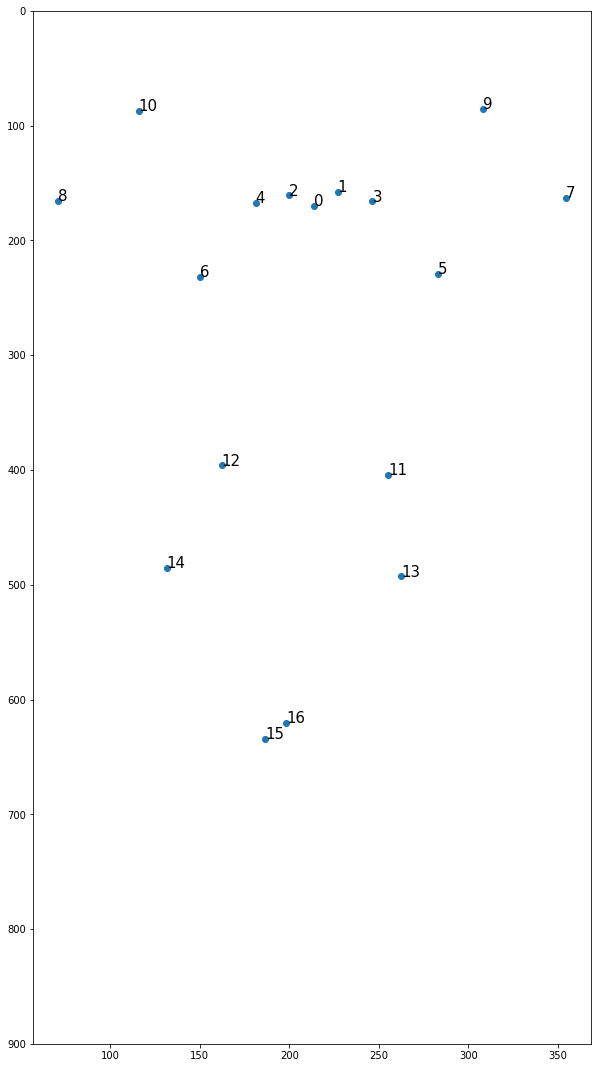

In [8]:
fig, ax = plt.subplots(figsize=(10,19))
ax.scatter(x, y)

for i, txt in enumerate(range(len(x))):
    ax.annotate(i, (x[i], y[i]),size=15)
    
plt.ylim(900,0)

In [9]:
x

array([213.49094, 226.98407, 199.99782, 246.41414, 181.10745, 283.11545,
       150.34314, 354.3591 ,  71.00359, 307.94278, 115.80075, 255.04974,
       162.21709, 262.6059 , 131.45277, 186.5047 , 198.37865],
      dtype=float32)

### Primera versión de la Posicion

In [10]:
class Posicion():
    
    def __init__(self,x,y):
        self.nariz = [x[0],y[0]]
        self.ojoI = [x[1],y[1]]
        self.ojoD = [x[2],y[2]]
        self.orejaI=[x[3],y[3]]
        self.orejaD=[x[4],y[4]]
        self.hombroI=[x[5],y[5]]
        self.hombroD=[x[6],y[6]]
        self.cuello = self.calcularPuntoMedio(self.hombroI,self.hombroD)
        self.angCuelloSupI = self.calcularAngulo(self.hombroI,self.cuello,self.nariz)
        self.angCuelloSupD = self.calcularAngulo(self.hombroD,self.cuello,self.nariz)
        self.codoI = [x[7],y[7]]
        self.codoD = [x[8],y[8]]
        self.manoI=[x[9],y[9]]
        self.manoD = [x[10],y[10]]
        self.yD = ((self.codoD[1]-self.hombroD[1])*(self.manoD[0]-self.hombroD[0])/(self.codoD[0]-self.hombroD[0]))+self.hombroD[1]
        self.angCodoI = self.calcularAngulo(self.hombroI,self.codoI,self.manoI)
        self.angCodoD = self.calcularAngulo(self.hombroD,self.codoD,self.manoD)
        self.angHombroI = self.calcularAngulo(self.cuello,self.hombroI,self.codoI)
        self.angHombroD = self.calcularAngulo(self.cuello,self.hombroD,self.codoD)
        self.caderaI = [x[11],y[11]]
        self.caderaD = [x[12],y[12]]
        self.cadera = self.calcularPuntoMedio(self.caderaI,self.caderaD)
        self.angCuelloInfI =self.calcularAngulo(self.hombroI,self.cuello,self.cadera)
        self.angCuelloInfD =self.calcularAngulo(self.hombroD,self.cuello,self.cadera)
        self.rodillaI = [x[13],y[13]]
        self.rodillaD = [x[14],y[14]]
        self.angCaderaI = self.calcularAngulo(self.cadera,self.caderaI,self.rodillaI)
        self.angCaderaD = self.calcularAngulo(self.cadera,self.caderaD,self.rodillaD)
        self.angCaderaTorsoI = self.calcularAngulo(self.cuello,self.cadera,self.caderaI)
        self.angCaderaTorsoD = self.calcularAngulo(self.cuello,self.cadera,self.caderaD)
        self.tobilloI = [x[15],y[15]]
        self.tobilloD = [x[16],y[16]]
        self.angRodillaI = self.calcularAngulo(self.caderaI,self.rodillaI,self.tobilloI)
        self.angRodillaD = self.calcularAngulo(self.caderaD,self.rodillaD,self.tobilloD)
        self.distAntebrazoI = self.calcularDistancia(self.manoI,self.codoI)
        self.distAntebrazoD = self.calcularDistancia(self.manoD,self.codoD)
        self.distBrazoI = self.calcularDistancia(self.codoI,self.hombroI)
        self.distBrazoD = self.calcularDistancia(self.codoD,self.hombroD)
        self.distCuello = self.calcularDistancia(self.nariz,self.cuello)
        self.distTronco = self.calcularDistancia(self.cuello,self.cadera)
        self.distMusloI = self.calcularDistancia(self.caderaI,self.rodillaI)
        self.distMusloD = self.calcularDistancia(self.caderaD,self.rodillaD)
        self.distPiernaI = self.calcularDistancia(self.rodillaI,self.tobilloI)
        self.distPiernaD = self.calcularDistancia(self.rodillaD,self.tobilloD)
        self.distHombros = self.calcularDistancia(self.hombroI,self.hombroD)
        self.distCadera = self.calcularDistancia(self.caderaI,self.caderaD)
        
    def calcularPuntoMedio(self,p1,p2):
        return [(p1[0]+p2[0])/2,(p1[1]+p2[1])/2]
    
    def calcularAngulo(self,p1,p2,p3):
        v1 = self.calcularVector(p1,p2)
        v2 = self.calcularVector(p3,p2)
        uv1 = v1 / np.linalg.norm(v1)
        uv2 = v2 / np.linalg.norm(v2)
        dp = np.dot(uv1, uv2)
        return math.degrees(np.arccos(dp))
    
    def calcularVector(self,p1,p2):
        return [p2[0]-p1[0],p2[1]-p1[1]]
    
    def calcularDistancia(self,p1,p2):
        return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5
    
    def devuelveAngulos(self):
        return [self.angCuelloSupI,self.angCuelloSupD,self.angCodoI,self.angCodoD,self.angHombroI,self.angHombroD,
               self.angCuelloInfI,self.angCuelloInfD,self.angCaderaI,self.angCaderaD,self.angRodillaI,self.angRodillaD,
               self.angCaderaTorsoI,self.angCaderaTorsoD]

### Función que permite imprimir un frame en concreto

In [11]:
def obtenerFrame(vid,frame):
    vc = cv2.VideoCapture(vid)

    if (vc.isOpened()==False):
        print("Error")
    else:
        for i in range(frame):
            ret,frame = vc.read()

    o = predictor(frame)
    v = Visualizer(frame[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v2 = v.draw_instance_predictions(o["instances"].to("cpu"))
    imVisualizer = cv2.cvtColor(v2.get_image()[:, :, ::-1],cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(18, 16))
    plt.imshow(imVisualizer)
    plt.show()
    
    pkP = o.get("instances").pred_keypoints
    if len(pkP)>0:
        x = pkP[0][:,0].cpu().numpy()
        y = pkP[0][:,1].cpu().numpy()
    return [x,y]

In [12]:
a = Posicion(x,y)

### Se obtienen todas las posciones de un vídeo

In [13]:
vc = cv2.VideoCapture('../pruebas/videos-prueba/Videos/Josemi/sentado3-caja.webm')

if (vc.isOpened()==False):
    print("Error")

(grabbed, frame) = vc.read()
pos = []
error = []
i = 0
while(vc.isOpened()):
    ret,frame = vc.read()
    if ret == True:
        o = predictor(frame)
        pkP = o.get("instances").pred_keypoints
        if len(pkP)>0 and len(pkP[0])==17:
            x = pkP[0][:,0].cpu().numpy()
            y = pkP[0][:,1].cpu().numpy()
        else: 
            error.append(i)
        pos.append(Posicion(x,y))
    else:
        break
    print("Frame " + str(i),end="\r")
    i+=1
vc.release()
cv2.destroyAllWindows()
if len(error) > 0:
    for j in error:
        print("El frame " + str(j) + " ha dado error.")

### Comparaciones

In [14]:
def comparaPosiciones(pos1,pos2):
    res=0.0
    ang1 = pos1.devuelveAngulos()
    ang2 = pos2.devuelveAngulos()
    for i in range(len(ang1)):
        res+= abs(ang1[i]-ang2[i])
    return res

In [15]:
def compararBrazosV1(pos1,po2):
    partes = ["D","I"]
    zonas = ["angCodo"]
    res = 0.0
    for i in partes:
        for j in zonas:
            res+=abs(eval("pos1."+j+i)-eval("pos2."+j+i))
    return res

In [16]:
def compararPiernasv1(pos1,pos2):
    partes = ["D","I"]
    zonas = ["angRodilla","angCadera"]
    res = 0.0
    for i in partes:
        for j in zonas:
            res+=abs(eval("pos1."+j+i)-eval("pos2."+j+i))
    return res

In [17]:
def compararTorso(pos1,pos2):
    partes=["D","I"]
    zonas=["angCaderaTorso","angHombro","angCuelloSup"]
    res = 0.0
    for i in partes:
        for j in zonas:
            res+=abs(eval("pos1."+j+i)-eval("pos2."+j+i))
    return res

In [18]:
def compararPosiciones2(pos1,pos2,penalizacion = 100,diferenciaPena = 5,pesoBrazos=1,pesoPiernas=1,pesoTorso=1):
    return pesoBrazos*compararBrazos(pos1,pos2,penalizacion,diferenciaPena)+pesoPiernas*compararPiernas(pos1,pos2)+pesoTorso*compararTorso(pos1,pos2)

In [19]:
# Comparación v2
#Penalización si los brazos están en sentidos contrarios
#Diferencia de grados para considerar a un brazo estirado, por lo que no se tiene que penalizar
def compararBrazosV2(pos1,pos2,penalizacionCodo = 180,penalizacionHombro=90, diferenciaEstirado=10):
    partes=["D","I"]
    res=0.0
    pos=[pos1,pos2]
    
    for j in partes:
        res+= abs(eval("pos1.angCodo"+j)-eval("pos2.angCodo"+j))
        res+= abs(eval("pos1.angHombro"+j)-eval("pos2.angHombro"+j))
        auxCodo = []
        auxHombro = []
        for i in pos:
            
            #Si el brazo está estirado
            if  180-diferenciaEstirado <= eval("i.angCodo"+j) <= 180+diferenciaEstirado:
                auxCodo.append(0)
            #Si no está estirado
            else:
                if eval("i.mano"+j+"[1]") > eval("i.codo"+j+"[1]"):
                    auxCodo.append(1)
                else: 
                    auxCodo.append(2)
            
            # Si el angulo del hombro es casi 180 entonces 0
            if  180-diferenciaEstirado <= eval("i.angHombro"+j) <= 180+diferenciaEstirado:
                auxHombro.append(0)
            #Sino comparar si está hacia arriba o hacia abajo
            else:
                if eval("i.codo"+j+"[1]") > eval("i.hombro"+j+"[1]"):
                    auxHombro.append(1)
                else:
                    auxHombro.append(2)
                    
        if (auxCodo[0] == 1 and  auxCodo[1]==2) or (auxCodo[0] == 2 and  auxCodo[1]==1):
            res+=penalizacionCodo
            print("Penalizado brazo " + j)
        if (auxHombro[0] == 1 and  auxHombro[1]==2) or (auxHombro[0] == 2 and  auxHombro[1]==1):
            res+=penalizacionHombro
            print("Penalizado hombro " + j)
    return res

#Penalización si los brazos están en sentidos contrarios
#Diferencia para designar si una brazo está al mismo nivel (0), está arriba (1) o abajo del codo (2)
def compararBrazosv2_0(pos1,pos2,penalizacion = 100,diferenciaPena = 5):
    res=0.0
    
    res+= abs(pos1.angCodoD-pos2.angCodoD)
    bD1 = 0
    
    #Si la diferencia de altura es superior a la establecida se comprueba si está por encima o por debajo
    if abs(pos1.manoD[1]*100/pos1.codoD[1]-100)>diferenciaPena:
        if pos1.manoD[1] > pos1.codoD[1]:
            bD1 = 1
        else: 
            bD1 = 2
    bD2 = 0
    if abs(pos2.manoD[1]*100/pos2.codoD[1]-100)>diferenciaPena:
        if pos2.manoD[1] > pos2.codoD[1]:
            bD2 = 1
        else: 
            bD2 = 2
    #Penalizamos
    if (bD1 == 1 and  bD2==2) or (bD1 == 2 and  bD2==1):
        res+=penalizacion
        print("Penalizado brazo derecho")
    
    res+= abs(pos1.angCodoI-pos2.angCodoI)
    
    bI1 = 0
    if abs(pos1.manoI[1]*100/pos1.codoI[1]-100)>diferenciaPena:
        if pos1.manoI[1] > pos1.codoI[1]:
            bI1 = 1
        else: 
            bI1 = 2
    bI2 = 0
    if abs(pos2.manoI[1]*100/pos2.codoI[1]-100)>diferenciaPena:
        if pos2.manoI[1] > pos2.codoI[1]:
            bI2 = 1
        else: 
            bI2 = 2
    #Penalizamos
    if (bI1 == 1 and  bI2==2) or (bI1 == 2 and  bI2==1):
        res+=penalizacion
        print("Penalizado brazo izquierdo")
    return res

def compararPiernasV2(pos1,pos2):
    partes = ["D","I"]
    zonas = ["angRodilla","angCadera"]
    res = 0.0
    for i in partes:
        for j in zonas:
            res+=abs(eval("pos1."+j+i)-eval("pos2."+j+i))
    return res

def compararTorsoV2(pos1,pos2):
    partes=["D","I"]
    zonas=["angCaderaTorso","angCuelloSup"]
    res = 0.0
    for i in partes:
        for j in zonas:
            res+=abs(eval("pos1."+j+i)-eval("pos2."+j+i))
    return res

def compararPosicionesV2(pos1,pos2,penalizacionCodo = 180,penalizacionHombro=90,diferenciaEstirado = 10,pesoBrazos=1,pesoPiernas=1,pesoTorso=1):
    return pesoBrazos*compararBrazosV2(pos1,pos2,penalizacion,diferenciaEstirado)+pesoPiernas*compararPiernasV2(pos1,pos2)+pesoTorso*compararTorsoV2(pos1,pos2)

In [20]:
# Comparación v3
#Penalización si los brazos están en sentidos contrarios
#Diferencia de grados para considerar a un brazo estirado, por lo que no se tiene que penalizar
def compararBrazosV3(pos1,pos2,penalizacionCodo = 180,penalizacionHombro=90, diferenciaEstirado=10):
    partes=["D","I"]
    res=0.0
    pos=[pos1,pos2]
    
    for j in partes:
        res+= abs(eval("pos1.angCodo"+j)-eval("pos2.angCodo"+j))
        res+= abs(eval("pos1.angHombro"+j)-eval("pos2.angHombro"+j))
        auxCodoAltura = []
        auxCodoAnchura = []
        auxHombro = []
        for i in pos:
            
            #Si el brazo está estirado
            if  180-diferenciaEstirado <= eval("i.angCodo"+j) <= 180:
                auxCodoAltura.append(0)
            #Si no está estirado
            else:
                if eval("i.mano"+j+"[1]") > eval("i.codo"+j+"[1]"):
                    auxCodoAltura.append(1)
                else: 
                    auxCodoAltura.append(2)
                if eval("i.mano"+j+"[0]") > eval("i.codo"+j+"[0]"):
                    aux
            
            # Si el angulo del hombro es casi 180 entonces 0
            if  180-diferenciaEstirado <= eval("i.angHombro"+j) <= 180:
                auxHombro.append(0)
            #Sino comparar si está hacia arriba o hacia abajo
            else:
                if eval("i.codo"+j+"[1]") > eval("i.hombro"+j+"[1]"):
                    auxHombro.append(1)
                else:
                    auxHombro.append(2)
                    
        if (auxCodoAltura[0] == 1 and  auxCodoAltura[1]==2) or (auxCodoAltura[0] == 2 and  auxCodoAltura[1]==1):
            #Están a alturas distintas, comprobar si están en anchos distintos
            if (auxCodoAltura[0] == 1 and  auxCodoAltura[1]==2) or (auxCodoAltura[0] == 2 and  auxCodoAltura[1]==1):
                res+=penalizacionCodo
                print("Penalizado codo " + j)
        if (auxHombro[0] == 1 and  auxHombro[1]==2) or (auxHombro[0] == 2 and  auxHombro[1]==1):
            res+=penalizacionHombro
            print("Penalizado hombro " + j)
    return res/(len(pos)*len(partes))


def compararPiernasV3(pos1,pos2):
    partes = ["D","I"]
    zonas = ["angRodilla","angCadera"]
    res = 0.0
    for i in partes:
        for j in zonas:
            res+=abs(eval("pos1."+j+i)-eval("pos2."+j+i))
    return res/(len(zonas)*len(partes))

def compararTorsoV3(pos1,pos2):
    partes=["D","I"]
    zonas=["angCaderaTorso","angCuelloSup"]
    res = 0.0
    for i in partes:
        for j in zonas:
            res+=abs(eval("pos1."+j+i)-eval("pos2."+j+i))
    return res/(len(zonas)*len(partes))

def compararPosicionesV3(pos1,pos2,penalizacionCodo = 180,penalizacionHombro=90,diferenciaEstirado = 10,pesoBrazos=1,pesoPiernas=1,pesoTorso=1):
    total = pesoBrazos+pesoPiernas+pesoTorso
    return (pesoBrazos/total)*compararBrazosV3(pos1,pos2,penalizacionCodo,penalizacionHombro,diferenciaEstirado)+(pesoPiernas/total)*compararPiernasV3(pos1,pos2)+(pesoTorso/total)*compararTorsoV3(pos1,pos2)

### Pruebas con los brazos - error

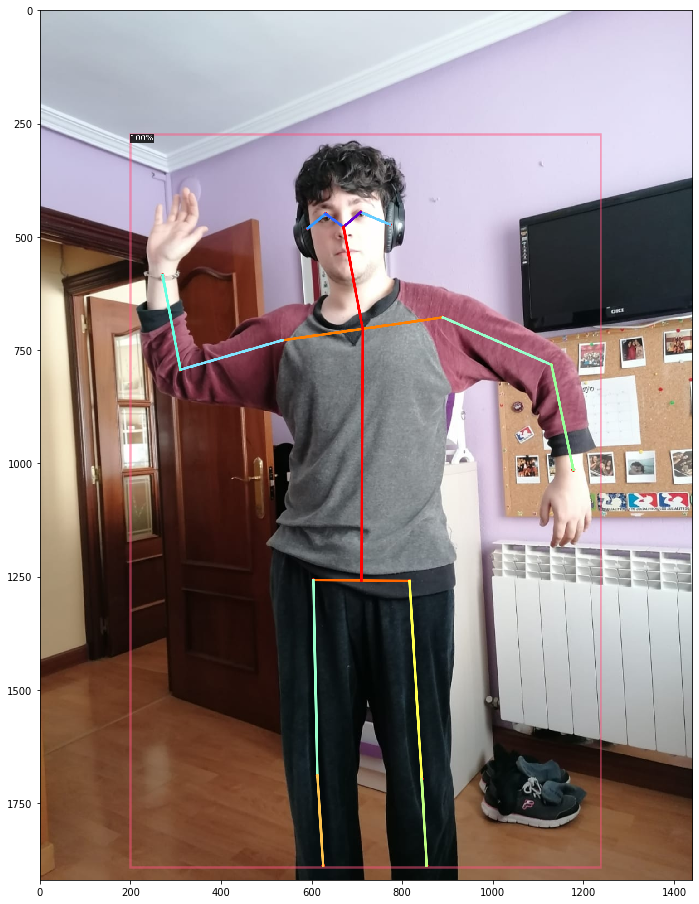

In [21]:
frame = cv2.imread("../pruebas/imagenes-prueba/PruebaBrazos.jpeg")
o = predictor(frame)
v = Visualizer(frame[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v2 = v.draw_instance_predictions(o["instances"].to("cpu"))
imVisualizer = cv2.cvtColor(v2.get_image()[:, :, ::-1],cv2.COLOR_BGR2RGB)
plt.figure(figsize=(18, 16))
plt.imshow(imVisualizer)
plt.show()

In [22]:
pkP = o.get("instances").pred_keypoints
if len(pkP)>0:
    x = pkP[0][:,0].cpu().numpy()
    y = pkP[0][:,1].cpu().numpy()

In [23]:
a = Posicion(x,y)

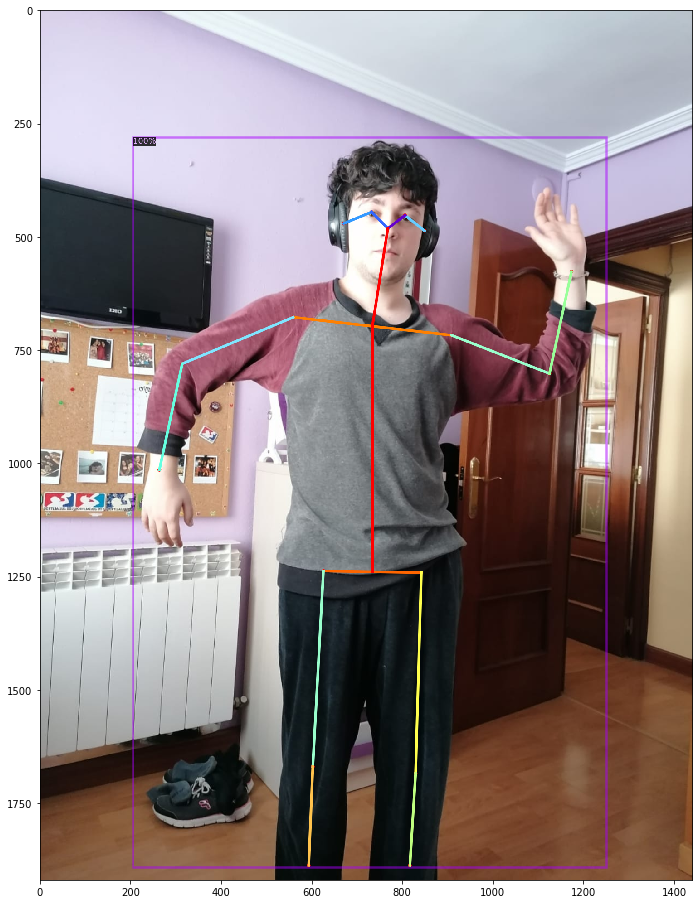

In [24]:
frame = cv2.imread("../pruebas/imagenes-prueba/PruebaBrazos2.png")
o2 = predictor(frame)
v = Visualizer(frame[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v2 = v.draw_instance_predictions(o2["instances"].to("cpu"))
imVisualizer = cv2.cvtColor(v2.get_image()[:, :, ::-1],cv2.COLOR_BGR2RGB)
plt.figure(figsize=(18, 16))
plt.imshow(imVisualizer)
plt.show()

In [25]:
pkP2 = o2.get("instances").pred_keypoints
if len(pkP2)>0:
    x2 = pkP2[0][:,0].cpu().numpy()
    y2 = pkP2[0][:,1].cpu().numpy()

In [26]:
b = Posicion(x2,y2)

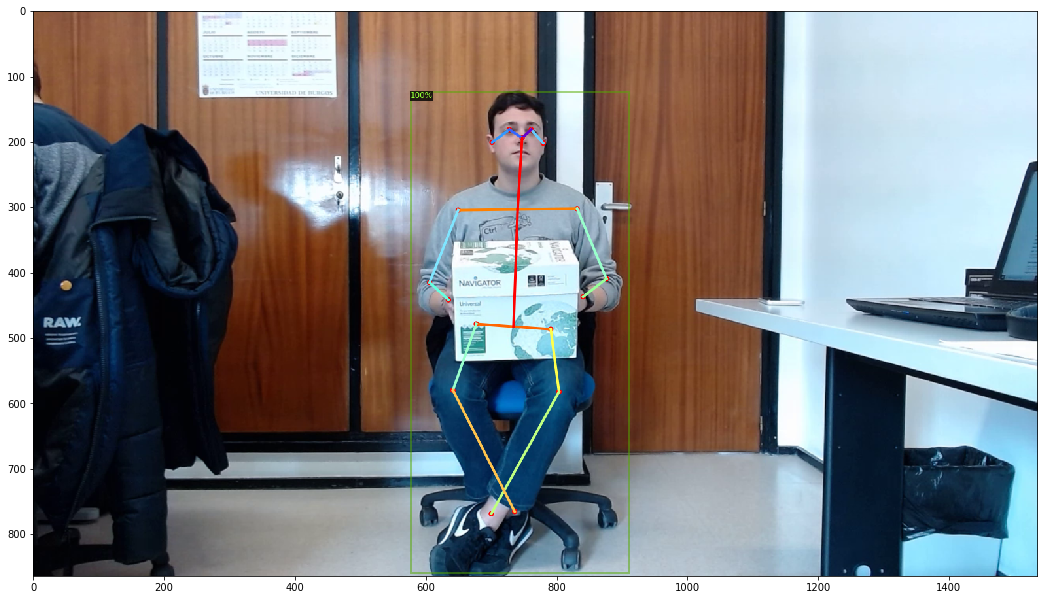

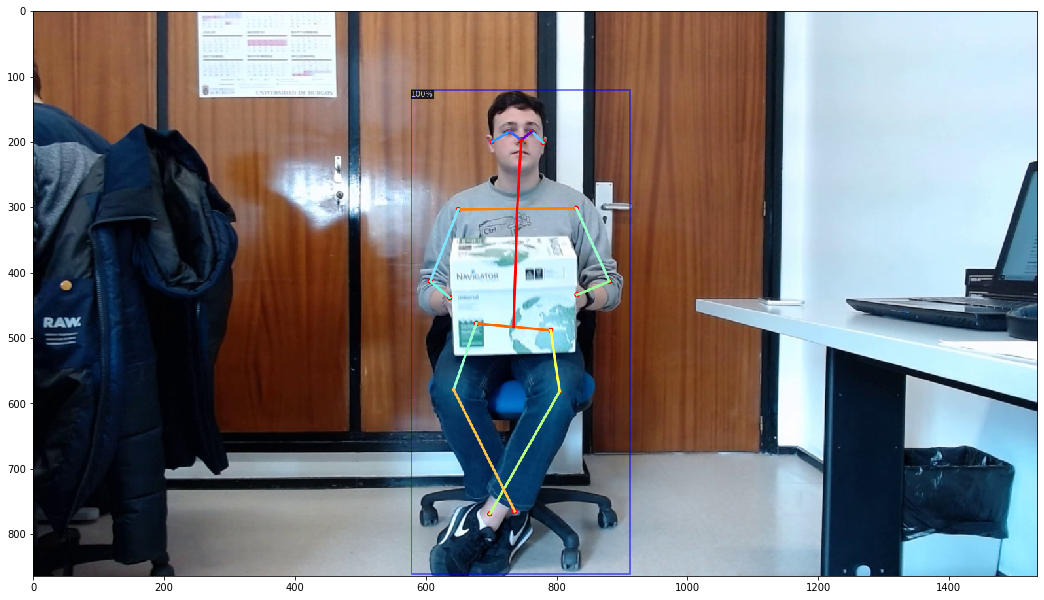

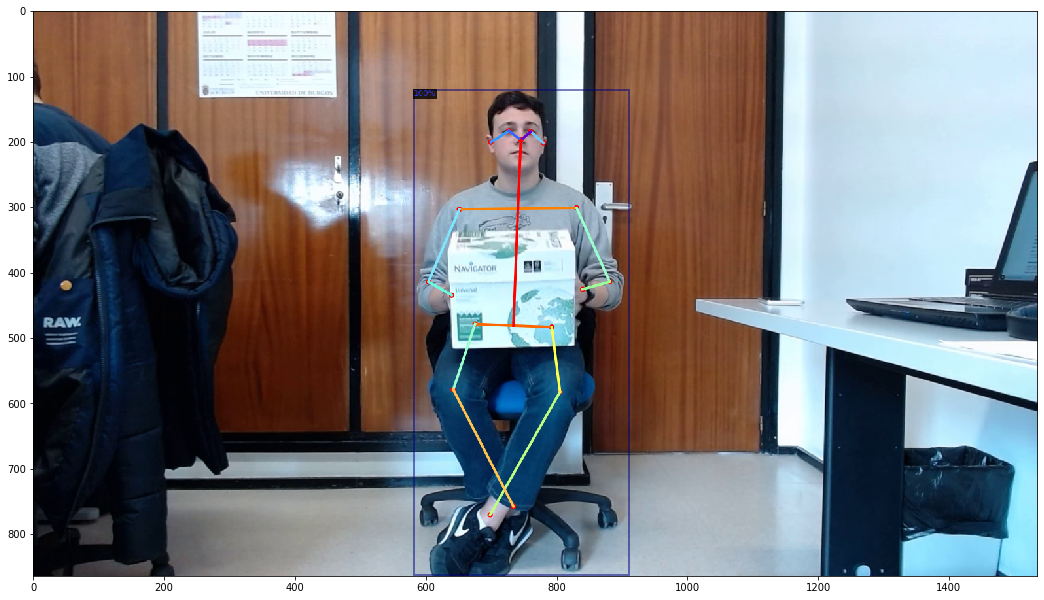

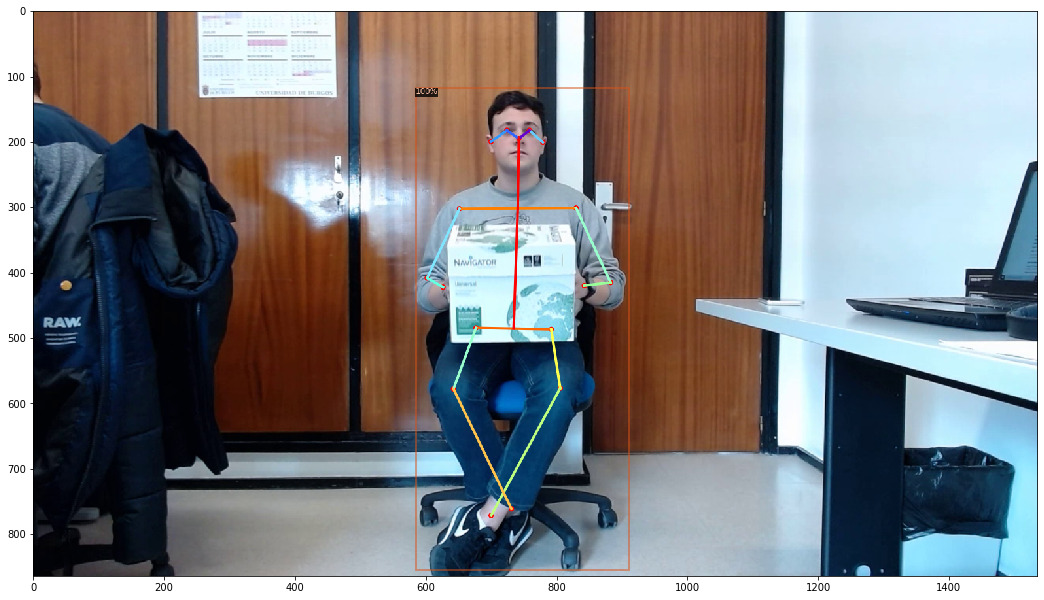

In [27]:
frames=[6,7,8,9]
for i in frames:
    obtenerFrame('../pruebas/videos-prueba/Videos/Josemi/sentado3-caja.webm',i)